In [1]:
from bloqade import piecewise_linear, piecewise_constant, rydberg_h
from bloqade.atom_arrangement import ListOfLocations,Honeycomb, Chain, Square
from qutip import *
import pandas as pd
import numpy as np
from bokeh.io import output_notebook
import matplotlib.pyplot as plt
output_notebook()

Loading BokehJS ...

In [2]:
sample_num = 100000

def ob_value(bin_str1, bin_str2):
    
    if len(bin_str1) != len(bin_str2):
        raise ValueError("Binary strings must have the same length")

    # Compute bitwise product (AND operation)
    bitwise_product = [int(b1) & int(b2) for b1, b2 in zip(bin_str1, bin_str2)]
    
    # Compute modulo 2 sum (XOR sum of all resulting bits)
    mod2_sum = sum(bitwise_product) % 2
    
    return mod2_sum

def z_exp(res, size):
    Z_ob = [format(1 << i, f'0{size}b') for i in range(size)]
    
    ave_z = []
    for ob in Z_ob:
        exp_ob = 0
        for key, value in res.items():
            if ob_value(key, ob) == 0:
                # ground state
                exp_ob = exp_ob - 1 * value
            else:
                # excited state
                exp_ob = exp_ob + 1 * value
        ave_z.append(exp_ob)
    exp_z = sum(ave_z)/len(ave_z)

    return exp_z

def zz_exp(res, size):
    ZZ_ob = []
    for i in range(size-1):
        first_bit = 1 << i
        second_bit = 1 << ((i + 1) % size)  # Wrap around for the last element
        ZZ_ob.append(format(first_bit | second_bit, f'0{size}b'))
    
    ave_zz = []
    for ob in ZZ_ob:
        exp_ob = 0
        for key, value in res.items():
            if ob_value(key, ob) == 0:
                # 00 or 11
                exp_ob = exp_ob + 1 * value
            else:
                # 01 or 10
                exp_ob = exp_ob - 1 * value
        ave_zz.append(exp_ob)
    exp_zz = sum(ave_zz)/len(ave_zz)

    return exp_zz

Load data

In [3]:
Ts = np.arange(6.0, 20.1, 0.1)

Z_obs = []
ZZ_obs = []

k = 0

for t in Ts:

    if k % 10 == 0:  
        print(k)
    k = k+1

    size = 6
    t_evol = 0.0182*t
    d = 6.54
    pos = []
    for i in range(size):
        pos.append((i*d, 0))
    delta = 0
    omega = 2.2
    phase = 0
    t_ramp = 0.05
    durations = [t_ramp,t_evol-t_ramp,t_ramp]
    delta_MHz =[0, delta, delta, 0]
    omega_MHz = [0, omega, omega, 0]
    phase_ = [phase, phase, phase]
    Delta = piecewise_linear(durations,[x*2*np.pi for x in delta_MHz])
    Omega = piecewise_linear(durations,[x*2*np.pi for x in omega_MHz])
    # Delta = piecewise_linear(durations,[x for x in delta_MHz])
    # Omega = piecewise_linear(durations,[x for x in omega_MHz])
    Phase = piecewise_constant(durations, phase_)

    program = rydberg_h(pos, detuning=Delta, amplitude=Omega, phase=Phase)
    output = program.bloqade.python().run(shots=sample_num, interaction_picture=True)
    bitstring_counts = output.report().counts()[0]
    total_count = sum(bitstring_counts.values())
    bitstring_probabilities = {key: value / total_count for key, value in bitstring_counts.items()}
    quera_res = bitstring_probabilities
    quera_res = {key.replace('0', 'x').replace('1', '0').replace('x', '1'): value for key, value in quera_res.items()}
    binary_length = size
    all_binary_keys = [format(i, f'0{binary_length}b') for i in range(2**binary_length)]
    for key in all_binary_keys:
        if key not in quera_res:
            quera_res[key] = 0
    quera_res = {key: quera_res[key] for key in sorted(quera_res)}

    Z_obs.append(z_exp(quera_res, size))
    ZZ_obs.append(zz_exp(quera_res, size))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


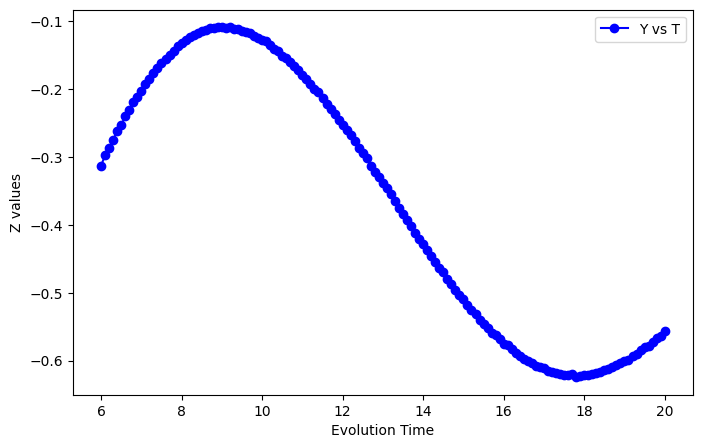

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(Ts, Z_obs, marker='o', linestyle='-', color='b', label="Y vs T")

# Labels and title
plt.xlabel("Evolution Time")
plt.ylabel("Z values")
plt.legend()
plt.show()

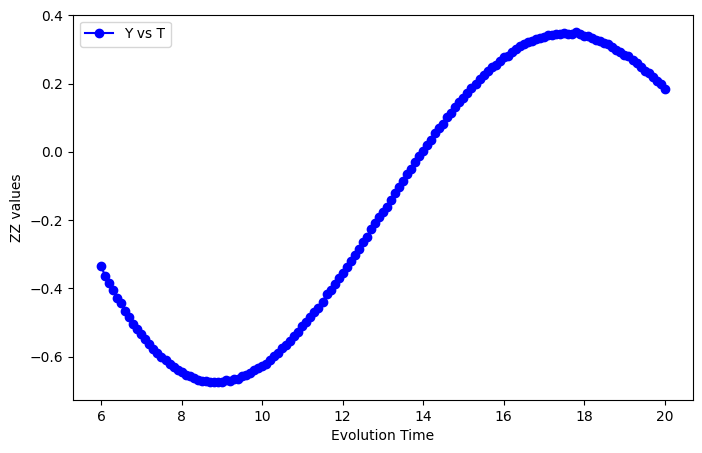

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(Ts, ZZ_obs, marker='o', linestyle='-', color='b', label="Y vs T")

# Labels and title
plt.xlabel("Evolution Time")
plt.ylabel("ZZ values")
plt.legend()
plt.show()

In [6]:
import json
data = {
    "exp_Z": Z_obs,
    "exp_ZZ": ZZ_obs
}

# Save to a JSON file
with open("opt.json", "w") as f:
    json.dump(data, f, indent=4)

print("Data saved successfully!")

Data saved successfully!
